In [1]:
import warnings
import pandas as pd
import numpy as np
import pymc3 as pm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
SEED = 14201

In [3]:
warnings.filterwarnings('ignore')

In [4]:
sns.set_context('talk')

# EDA

Scottish hills dataset (race times with distance covered)

In [5]:
# Load data
df = sm.datasets.get_rdataset('hills', 'MASS').data

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
dist,35.0,7.528571,5.523936,2.00,4.5,6.00,8.000,28.000
climb,35.0,1815.314286,1619.150536,300.00,725.0,1000.00,2200.000,7500.000
time,35.0,57.875714,50.040716,15.95,28.0,39.75,68.625,204.617


In [7]:
# outlier from data entry error
df.loc['Knock Hill']

dist       3.00
climb    350.00
time      78.65
Name: Knock Hill, dtype: float64

# Models

**Model specification:** `time` is a linear combination of `dist` and `climb`.

In [8]:
y_list = ['time']
X_list = ['dist', 'climb']

In [9]:
def formula_string(y_list, X_list):
    return y_list[0] + ' ~ ' + ' + '.join(X_list)

In [10]:
model_spec = formula_string(y_list, X_list)
print(model_spec)

time ~ dist + climb


The expectation in the model: races with longer distances (`dist`) take more time to complete (`time`).

Also include `climb` as a regressor.  Races on hilly terrain is more demanding for runners than races that have little change in altitude, so all things constant we may reason that races that involve an ascent take longer to complete.

In [11]:
X = df[X_list]

## Bayesian modelling

Set up functions for **robust regression via PyMC**.

In [12]:
def get_model(df, *, family):
    if family == 't':
        fam =  pm.glm.families.StudentT()
    elif family == 'normal':
        fam = pm.glm.families.Normal()
    else:
        raise ValueError('Specify t or normal for family')
    
    with pm.Model() as model:
        priors = {'Intercept': pm.Normal.dist(mu=df[y_list].iloc[:, 0].mean(),
                                              sigma=df[y_list].iloc[:, 0].std()),
                  'dist': pm.Normal.dist(mu=0, sigma=df['dist'].std()),
                  'climb': pm.Normal.dist(mu=0, sigma=df['climb'].std())
                  }

        y_likelihood = pm.glm.GLM.from_formula(model_spec, df,
                                               family=fam, priors=priors)
    return model

In [13]:
def do_model_inference(*, model, random_seed, draws=2000, tune=1000):
    with model:
        trace = pm.sample(draws, tune=tune, random_seed=SEED,
                          step=pm.NUTS(), start=pm.find_MAP())
    return trace

In [14]:
model_t = get_model(df, family='t')
model_norm = get_model(df, family='normal')

In [15]:
trace_t = do_model_inference(model=model_t, random_seed=SEED)

logp = -142.25, ||grad|| = 0.83952: 100%|██████████| 103/103 [00:00<00:00, 2949.10it/s] 
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam, climb, dist, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:09<00:00, 1308.79draws/s]
The acceptance probability does not match the target. It is 0.9195845322270142, but should be close to 0.8. Try to increase the number of tuning steps.


**Show model results:** t-distributed errors

In [16]:
pm.summary(trace_t)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-7.746,1.878,-11.176,-4.141,0.034,0.024,3010.0,3010.0,3550.0,2390.0,1.0
dist,6.512,0.304,5.903,6.956,0.007,0.005,1853.0,1853.0,3008.0,1971.0,1.0
climb,0.007,0.001,0.005,0.009,0.000,0.000,3563.0,3342.0,3842.0,2942.0,1.0
lam,0.126,0.064,0.036,0.243,0.001,0.001,4274.0,3715.0,4931.0,3981.0,1.0


In [17]:
trace_norm = do_model_inference(model=model_norm, random_seed=SEED)

logp = -163.57, ||grad|| = 25.934: 100%|██████████| 81/81 [00:00<00:00, 2307.68it/s]       
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, climb, dist, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:07<00:00, 1626.19draws/s]


**Show model results:** normally-distributed errors

In [18]:
pm.summary(trace_norm)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-8.241,4.344,-16.634,-0.280,0.064,0.047,4625.0,4323.0,4648.0,4535.0,1.0
dist,6.108,0.613,4.991,7.261,0.010,0.007,3895.0,3869.0,3901.0,3808.0,1.0
climb,0.011,0.002,0.007,0.015,0.000,0.000,3998.0,3998.0,4032.0,4185.0,1.0
sd,14.936,1.904,11.619,18.528,0.027,0.019,5135.0,4962.0,5257.0,4640.0,1.0


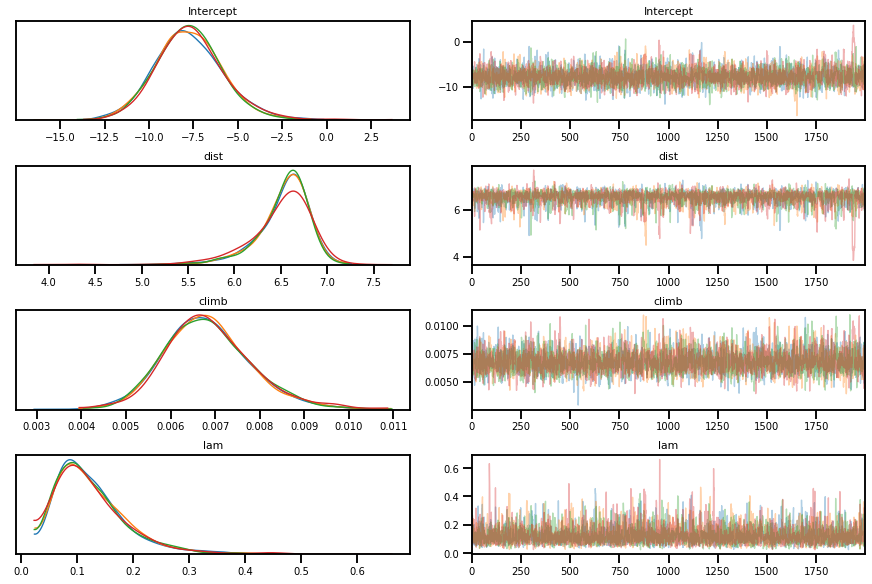

In [19]:
pm.traceplot(trace_t);

In [20]:
results_pp_t = pm.summary(trace_t)
results_pp_t

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-7.746,1.878,-11.176,-4.141,0.034,0.024,3010.0,3010.0,3550.0,2390.0,1.0
dist,6.512,0.304,5.903,6.956,0.007,0.005,1853.0,1853.0,3008.0,1971.0,1.0
climb,0.007,0.001,0.005,0.009,0.000,0.000,3563.0,3342.0,3842.0,2942.0,1.0
lam,0.126,0.064,0.036,0.243,0.001,0.001,4274.0,3715.0,4931.0,3981.0,1.0


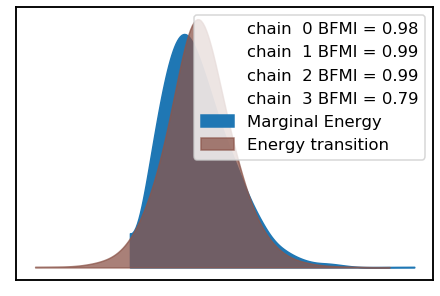

In [21]:
pm.plots.energyplot(trace_t);

This is a multivariate model, so do plotting with `pm.plot_posterior_predictive_glm` based on a `lm` parameter mapping (instead of `pm.hpd`).

In [22]:
def lm_mean(trace, dist):
    shape = np.broadcast(X).shape
    x_norm = np.asarray([dist, X.mean().loc['climb']])

    return (trace['Intercept'] + trace['dist']*x_norm[0] +
            trace['climb']*(x_norm[1]))

In [23]:
lm = lambda x, samples: lm_mean(samples, x)
x_range_for_plot = np.linspace(df['dist'].min(), df['dist'].max(), 500)

Sample from the trace of each model 100 times, evaluating the model at the mean values for all regressors.

- **Purple lines:** Bayesian regression (Student's t distribution for errors)
- **Orange lines:** Bayesian regression (Normal distribution for errors)

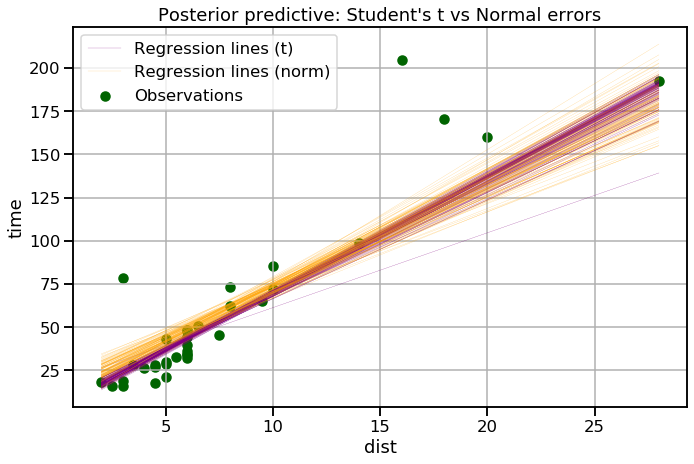

In [24]:
fig, ax = plt.subplots(figsize=(11,7))
ax.scatter(df['dist'], df[y_list], label='Observations', color='darkgreen')
pm.plot_posterior_predictive_glm(trace_t, eval=x_range_for_plot, lm=lm, samples=100,
                                 color="purple", alpha=1,
                                 label='Regression lines (t)')
pm.plot_posterior_predictive_glm(trace_norm, eval=x_range_for_plot, lm=lm, samples=100,
                                 color="orange", alpha=0.7,
                                 label='Regression lines (norm)')
ax.grid()
ax.set_xlabel('dist')
ax.set_ylabel('time')
ax.set_title("Posterior predictive: Student's t vs Normal errors")
ax.legend()
plt.show()

The extreme values in the dataset have high values for `time` (dependent variable) relative to the fitted model, so there are a few outliers.

**The regression model with Student's t errors is less sensitive to outliers.**  Notice that the regression lines sampled with Student's t errors (compared to the lines with normally distributed errors) on the whole:
- Have a steeper gradient for `time` on `dist`
- Have a lower intercept
- Have less variation (the standard deviation for the `dist` estimate is much lower)

For both flavours of Bayesian regression, there is more variance in the regression lines at the higher values of `dist`.  There are relatively few observations in the right tail of the `dist` distribution.

## OLS

Let's examine a regression model esimated via OLS (with heteroskedasticity-robust standard errors).

In [25]:
model_lm = sm.OLS(df[y_list], sm.add_constant(df[X_list]))
results_lm = model_lm.fit(cov_type='HC1')

In [26]:
results_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     280.3
Date:                Sat, 15 Feb 2020   Prob (F-statistic):           5.21e-21
Time:                        21:52:33   Log-Likelihood:                -142.11
No. Observations:                  35   AIC:                             290.2
Df Residuals:                      32   BIC:                             294.9
Df Model:                           2                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.9920      5.234     -1.718      0.086     -19.251       1.267
dist           6.2180      0.368     16.911      0.000       5.497       6.939
climb          0.0110      0.003      3.821      0.000       0.005       0.017
==============================================================================
Omnibus:                       47.910   Durbin-Watson:                   2.249
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              233.976
Skew:                           3.026   Prob(JB):                     1.56e-51
Kurtosis:                      14.127   Cond. No.                     4.20e+03
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 4.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
print('Root MSE: {:.3f}'.format(np.sqrt(results_lm.mse_resid)))

Root MSE: 14.676


### Diagnostics

**Examine outliers** in the model fitted via OLS estimation.

In [28]:
results_lm.get_influence().summary_frame()['student_resid'].sort_values().head()

Ben Nevis    -1.186396
Cairngorm    -0.980945
Black Hill   -0.873713
Ben Lomond   -0.866026
Creag Dubh   -0.819995
Name: student_resid, dtype: float64

In [29]:
results_lm.get_influence().summary_frame()['student_resid'].sort_values().tail()

Lairig Ghru      0.526858
Cairn Table      0.714568
Two Breweries    0.733549
Bens of Jura     3.168980
Knock Hill       7.610845
Name: student_resid, dtype: float64

**Knock Hill** is a prominent outlier and this is in fact due to a measurement error.  The true value of `dist` is much lower for the `dist` recorded.

In [30]:
fitted_line_xlm, fitted_line_ylm = [], []

for val in np.arange(df['dist'].min(), df['dist'].max(), step=0.1):
    fitted_line_xlm.append(val)
    fitted_line_ylm.append(results_lm.params.loc['const']
                           + results_lm.params.loc['dist'] * val
                           + results_lm.params.loc['climb'] * X.mean().loc['climb'])

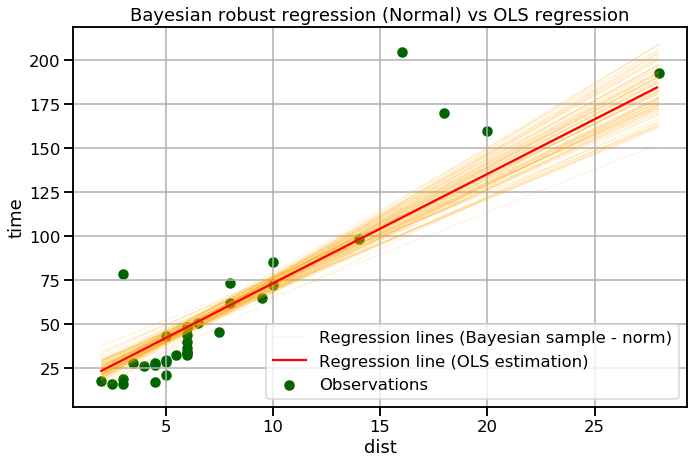

In [31]:
fig, ax = plt.subplots(figsize=(11,7))
plt.scatter(df['dist'], df[y_list], label='Observations', color='darkgreen')
pm.plot_posterior_predictive_glm(trace_norm, eval=x_range_for_plot, lm=lm, samples=100,
                                 color="orange", alpha=.7,
                                 label='Regression lines (Bayesian sample - norm)')
plt.plot(fitted_line_xlm, fitted_line_ylm, label='Regression line (OLS estimation)',
         color='red')
ax.legend()
ax.set_xlabel('dist')
ax.set_ylabel('time')
ax.set_title("Bayesian robust regression (Normal) vs OLS regression")
ax.grid()
plt.show()

The regression line estimated via OLS is located centrally in the range of regression lines sampled via Bayesian regression techniques (normally distributed errors), as expected.

# Models on modified dataset

The time for the `Knock Hill` observation is an inaccurate.

Instead of 78.65 minutes, the time should be 18.65 minutes.  This measurement error is why the observation in the original dataset is a notable outlier.

Make a new dataframe, `df_modified`, which changes this observation.

In [32]:
df_modified = df.copy()

In [33]:
df_modified.loc['Knock Hill', 'time'] = 18.65

## OLS

Run a regression model via OLS estimation with the same specification of variables.

In [34]:
model_llm = sm.OLS(df_modified[y_list], sm.add_constant(df_modified[X_list]))
results_llm = model_llm.fit(cov_type='HC1')

In [35]:
results_llm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     643.1
Date:                Sat, 15 Feb 2020   Prob (F-statistic):           1.45e-26
Time:                        21:52:34   Log-Likelihood:                -124.21
No. Observations:                  35   AIC:                             254.4
Df Residuals:                      32   BIC:                             259.1
Df Model:                           2                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.9420      2.655     -4.874      0.000     -18.146      -7.738
dist           6.3456      0.310     20.496      0.000       5.739       6.952
climb          0.0118      0.003      4.672      0.000       0.007       0.017
==============================================================================
Omnibus:                        7.140   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                6.735
Skew:                           0.610   Prob(JB):                       0.0345
Kurtosis:                       4.770   Cond. No.                     4.20e+03
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 4.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
print('Root MSE: {:.3f}'.format(np.sqrt(results_llm.mse_resid)))

Root MSE: 8.800


Notice that from that change in the y-value for one observation, with the regression estimated by OLS:
- There is a steeper gradient for the `dist` coefficient.
- The model has higher R-squared.

## Bayesian model

Run Bayesian regression models with the same specification on this modified dataset.

In [37]:
model_t_modified = get_model(df_modified, family='t')
model_norm_modified = get_model(df_modified, family='normal')

In [38]:
trace_t_modified = do_model_inference(model=model_t_modified, random_seed=SEED)

logp = -137.25, ||grad|| = 0.51791: 100%|██████████| 112/112 [00:00<00:00, 2229.59it/s] 
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam, climb, dist, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:10<00:00, 1095.91draws/s]


In [39]:
trace_norm_modified = do_model_inference(model=model_norm_modified, random_seed=SEED)

logp = -146.22, ||grad|| = 169.29: 100%|██████████| 80/80 [00:00<00:00, 2989.77it/s]       
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, climb, dist, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:07<00:00, 1596.29draws/s]


In [40]:
pm.summary(trace_t_modified)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-6.991,1.920,-10.711,-3.252,0.040,0.028,2338.0,2338.0,2593.0,1545.0,1.0
dist,6.459,0.340,5.707,6.948,0.009,0.006,1534.0,1534.0,2394.0,1355.0,1.0
climb,0.007,0.001,0.005,0.008,0.000,0.000,3350.0,3215.0,3468.0,3484.0,1.0
lam,0.138,0.073,0.036,0.261,0.001,0.001,2776.0,2105.0,3833.0,2756.0,1.0


In [41]:
pm.summary(trace_norm_modified)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-12.603,2.726,-17.771,-7.394,0.042,0.030,4160.0,4160.0,4193.0,4044.0,1.0
dist,6.305,0.380,5.596,7.030,0.006,0.004,3785.0,3779.0,3790.0,3882.0,1.0
climb,0.012,0.001,0.009,0.014,0.000,0.000,4144.0,4144.0,4169.0,3896.0,1.0
sd,9.049,1.188,6.911,11.207,0.017,0.012,4929.0,4881.0,4893.0,4492.0,1.0


The standard deviation for the `dist` variable is much lower for the Bayesian model with normally-distributed errors under the modified dataset compared to the original dataset.

Under the modified dataset, the standard deviations estimated for `dist` in the model with t-distributed errors is much closer now to the model with normally-distributed errors.

That shows how one prominent outlier can affect estimation when using normally-distributed errors.

In [42]:
(pd.concat([pm.summary(trace_norm_modified).loc[:, 'mean'].rename('bayes_norm_modified_est'),
            pm.summary(trace_norm).loc[:, 'mean'].rename('bayes_norm_orig_est')], axis=1))

,bayes_norm_modified_est,bayes_norm_orig_est
Intercept,-12.603,-8.241
dist,6.305,6.108
climb,0.012,0.011
sd,9.049,14.936


For the model with **normally-distributed errors**, the coefficient of `dist` is higher in the modified dataset.

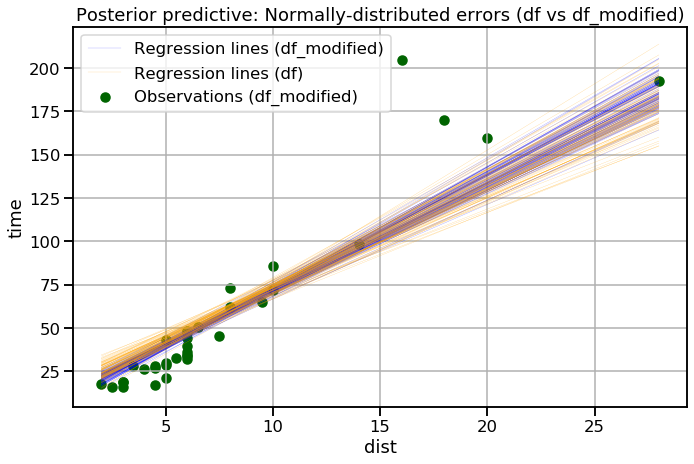

In [43]:
fig, ax = plt.subplots(figsize=(11,7))
ax.scatter(df_modified['dist'], df_modified[y_list], label='Observations (df_modified)', color='darkgreen')
pm.plot_posterior_predictive_glm(trace_norm_modified, eval=x_range_for_plot, lm=lm, samples=100,
                                 color="blue", alpha=0.7,
                                 label='Regression lines (df_modified)')
pm.plot_posterior_predictive_glm(trace_norm, eval=x_range_for_plot, lm=lm, samples=100,
                                 color="orange", alpha=0.7,
                                 label='Regression lines (df)')
ax.grid()
ax.set_xlabel('dist')
ax.set_ylabel('time')
ax.set_title("Posterior predictive: Normally-distributed errors (df vs df_modified)")
ax.legend()
plt.show()

In [44]:
(pd.concat([pm.summary(trace_t_modified).loc[:, 'mean'].rename('bayes_t_modified_est'),
            pm.summary(trace_t).loc[:, 'mean'].rename('bayes_t_orig_est')], axis=1))

,bayes_t_modified_est,bayes_t_orig_est
Intercept,-6.991,-7.746
dist,6.459,6.512
climb,0.007,0.007
lam,0.138,0.126


For the model with **t-distributed errors**, the coefficient of `dist` has little difference.

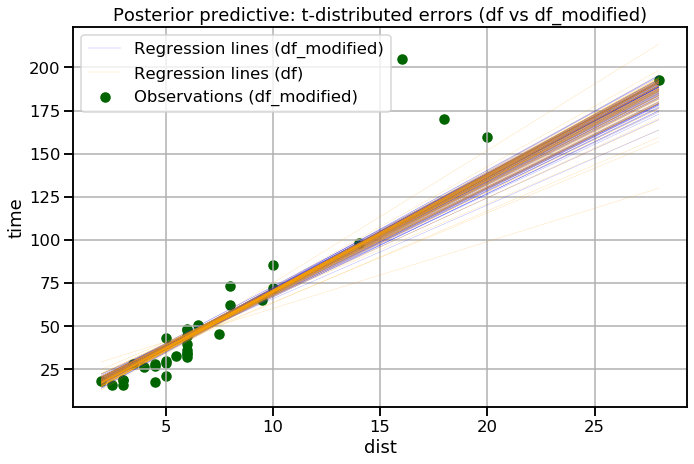

In [45]:
fig, ax = plt.subplots(figsize=(11,7))
ax.scatter(df_modified['dist'], df_modified[y_list], label='Observations (df_modified)', color='darkgreen')
pm.plot_posterior_predictive_glm(trace_t_modified, eval=x_range_for_plot, lm=lm, samples=100,
                                 color="blue", alpha=0.7,
                                 label='Regression lines (df_modified)')
pm.plot_posterior_predictive_glm(trace_t, eval=x_range_for_plot, lm=lm, samples=100,
                                 color="orange", alpha=0.7,
                                 label='Regression lines (df)')
ax.grid()
ax.set_xlabel('dist')
ax.set_ylabel('time')
ax.set_title("Posterior predictive: t-distributed errors (df vs df_modified)")
ax.legend()
plt.show()